<a href="https://colab.research.google.com/github/AMRISMA/DataScience/blob/master/Logistic_Regression_DIffPrivacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data") #Import dataset

In [2]:
!pip install diffprivlib

import diffprivlib.models as dp
import numpy as np
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 167 kB 10.0 MB/s 
     |████████████████████████████████| 1.6 MB 51.3 MB/s 
  Created wheel for crlibm: filename=crlibm-1.0.3-cp37-cp37m-linux_x86_64.whl size=175324 sha256=f3352e04ebed0a7424a1cab7d3c000f69b772badb66f312504541ecd0ed51035
  Stored in directory: /root/.cache/pip/wheels/d5/49/76/c2047e63fe9162b0b156dd4c0656b5ee1e3d8a2d6cfc56132c
Successfully built crlibm


In [3]:
X_train = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=(0, 4, 10, 11, 12), delimiter=", ") # only use integer features for training

y_train = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=14, dtype=str, delimiter=", ") # set last column as prediction label
np.unique(y_train)

array(['<=50K', '>50K'], dtype='<U5')

In [4]:
X_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=(0, 4, 10, 11, 12), delimiter=", ", skiprows=1)

y_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=14, dtype=str, delimiter=", ", skiprows=1)

y_test = np.array([a[:-1] for a in y_test]) # Must trim trailing period "." from label

np.unique(y_test)

array(['<=50K', '>50K'], dtype='<U5')

In [5]:
logreg = Pipeline([
    ('scaler', MinMaxScaler()), # scale min max of features to better fit sigmoid curve, control norm of data
    ('clf', LogisticRegression(solver="lbfgs")) # this process is smoothen by using pipeline in sklearn
])

In [6]:
logreg.fit(X_train, y_train)

print("Vanilla test accuracy: %.2f%%" % (accuracy_score(y_test, logreg.predict(X_test)) * 100))

Vanilla test accuracy: 81.04%


In [7]:
dp_logreg = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', dp.LogisticRegression())
])

dp_logreg.fit(X_train, y_train)

print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" % 
     (dp_logreg['clf'].epsilon, accuracy_score(y_test, dp_logreg.predict(X_test)) * 100))

Differentially private test accuracy (epsilon=1.00): 80.82%


/usr/local/lib/python3.7/dist-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)


In [8]:
dp_logreg = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', dp.LogisticRegression(epsilon=float("inf"), data_norm=2))
])

dp_logreg.fit(X_train, y_train)

print("Similarity between vanilla and differentially private (epsilon=inf) classifiers: %.2f%%" % 
     (accuracy_score(logreg.predict(X_test), dp_logreg.predict(X_test)) * 100))

Similarity between vanilla and differentially private (epsilon=inf) classifiers: 100.00%


In [9]:
accuracy = [accuracy_score(y_test, logreg.predict(X_test))]
epsilons = np.logspace(-3, 1, 500)

for eps in epsilons:
    dp_logreg.set_params(clf__epsilon=eps).fit(X_train, y_train)
    accuracy.append(accuracy_score(y_test, dp_logreg.predict(X_test)))


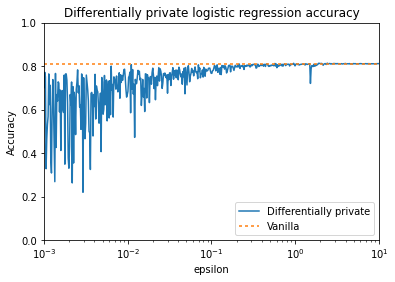

In [10]:
import pickle # result is saved using pickle so as to be use for plotting graph
import matplotlib.pyplot as plt

pickle.dump((epsilons, accuracy), open("logreg_accuracy_500.p", "wb" ) )

epsilons, accuracy = pickle.load(open("logreg_accuracy_500.p", "rb"))

plt.semilogx(epsilons, accuracy[1:], label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * accuracy[0], dashes=[2,2], label="Vanilla")
plt.title("Differentially private logistic regression accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=4)
plt.show()